### Autoencoder for 이상치 검출 
- 보통 이미지를 수치화 하고 그것을 이용 이미지를 만들어서 실제 이미지와 비교
- 비지도 학습 unsupervisor learning
- Auto-encoder는 다차원 데이터를 저차원으로 바꾸고 바꾼 저차원 데이터를 다시 고차원 데이터로 바꾸면서 특징점을 찾아낸다.
- 입력 데이터의 특징을 효율적으로 찾는다.
- 입력한 데이터의 비해 정보의 차원이 줄기 때문에 잡음 성분을 제거하는 용도로 사용한다.
- 주로 활용되는 분야는 데이터 압축, 저차원화를 통한 데이터 관찰,배경 잡음 억젝등이 있다.
- PCA를 확장 시킨 것으로 볼수 있다.(차원축소 특징을 잡아내는 것)

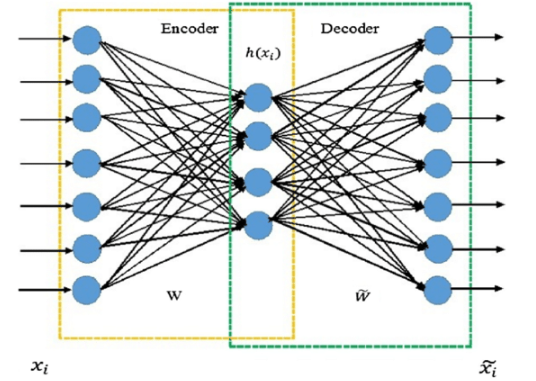

# AutoEncoder : 이상거래 탐지 실습

### 고안

*흐름 (초기에 고민한 흔적. 하지만 문제를 잘 이해하지 못했다)

1. raw데이터에서 시간 컬럼만 드랍한 뒤 - class 빼고 스케일 - autoencoder  --- 복구된 데이터
2. 복구된 데이터의 class 컬럼을 반올림한다
3. y_train아니냐? 왜 ddd다시 gogo y_test(애초에 빼놓은 시리즈) 와 2번 값을 비교한다.   (복구데이터['Class'] == y_test).mean() 하면 성능평가 할 수 있지 않을까?


*흐름(모든 과정을 끝낸 뒤 정리)

1. 다차원 데이터 -> 저차원 데이터 - >다차원 데이터

2. 여기서, 다차원에서 저차원으로 변환될 때 잡음(이상거래 약 500건)이 줄어들기 때문에 
저차원에서 다차원으로(output) 최종변환 될 때 정상거래의 형태(추세?)로 복원될 가능성이 높은 것 같다.

3. 가정 : X_test 값(실제값, 이상거래 포함)과 예측값(모델로 X_test를 predict해서 정상거래의 추세(?)로 출력. 즉, 잡음이 제거된 상태)의 MSE 수치는
이상거래에서 더 높을 것이다
  - error : 차이(빼기) // Square : 제곱 // Mean : 평균 ==> 차이(뺀 값)를 제곱해서 평균  ==> 평균제곱오차(오차제곱평균이 더 직관적...)
 
4. 검증 : Class(0: 정상거래, 1: 이상거래)와 MSE를 대응하여 데이터프레임으로 만들고, X_test와 예측값의 mse를 구한 뒤 mse를 내림차순으로 정렬하면 Class값이 1이 대부분이다

### 응용

1. 이번 예에서는 Class 라는 Lable 값이 주어졌기 때문에 완전한 비지도학습이라고 보기 힘들다.


2. 그러나, 라벨값이 없는 데이터셋이 주어져도 Autoencoder -> X_test와 예측값의 MSE 구하기 -> 'MSE가 높은 순으로 정렬' 하게되면, 상위 일부분을 이상치라고 추정할 수 있다.

In [1]:
## 1. 라이브러리

In [2]:
import pandas as pd
import numpy as np 
import tensorflow as tf
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
# from show_confusion_matrix import 
%matplotlib inline


C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\Users\user\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 2. EDA

In [3]:
df = pd.read_csv('creditcard.csv')

In [4]:
list_2=[]
for i in range(len(df)):
    if df['Class'][i] == 1:
        list_2.append(df['Class'][i])

In [5]:
len(list_2)

492

In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Null값 확인

In [7]:
# df.isnull().sum()

In [8]:
# df.info()

Amount(거래금액)과 이상유무의 상관관계

In [9]:
# f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(15,10))

# ax1.hist(df.Amount[df.Class == 1], bins = 100)
# ax1.set_title('Fraud')


# ax2.hist(df.Amount[df.Class == 0], bins = 100)
# ax2.set_title('Normal')

# ax3.hist(df.Amount, bins=100)
# ax3.set_title('All transaction')
# plt.xlabel('Amount')
# plt.ylabel('Number of Transactions')

# plt.yscale('log')
# plt.show()

# # amonut가 특정 값일 때 비정상 transaction이 집중적으로 일어났네

### sns.displot 시각화

In [10]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [11]:
# df[cn][0:10]

* distplot

In [12]:
# v_features = df.ix[:,1:29].columns

# plt.figure(figsize=(12,28*4))
# gs = gridspec.GridSpec(28, 1)
# for i, cn in enumerate(df[v_features]):
#     ax = plt.subplot(gs[i])
#     sns.distplot(df[cn][df.Class == 1], bins=50)
#     sns.distplot(df[cn][df.Class == 0], bins=50)
#     ax.set_xlabel('')
#     ax.set_title('histogram of feature: ' + str(cn))
    
# plt.show()

## 3. 전처리

In [13]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [14]:
df.drop('Time', axis=1, inplace =True)
df.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


## 4. Scale

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler = MinMaxScaler()

In [17]:
df_s= scaler.fit_transform(df)

In [18]:
df = pd.DataFrame(df_s, columns=df.columns)

In [19]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.935192,0.766490,0.881365,0.313023,0.763439,0.267669,0.266815,0.786444,0.475312,0.510600,...,0.561184,0.522992,0.663793,0.391253,0.585122,0.394557,0.418976,0.312697,0.005824,0.0
1,0.978542,0.770067,0.840298,0.271796,0.766120,0.262192,0.264875,0.786298,0.453981,0.505267,...,0.557840,0.480237,0.666938,0.336440,0.587290,0.446013,0.416345,0.313423,0.000105,0.0
2,0.935217,0.753118,0.868141,0.268766,0.762329,0.281122,0.270177,0.788042,0.410603,0.513018,...,0.565477,0.546030,0.678939,0.289354,0.559515,0.402727,0.415489,0.311911,0.014739,0.0
3,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.789434,0.414999,0.507585,...,0.559734,0.510277,0.662607,0.223826,0.614245,0.389197,0.417669,0.314371,0.004807,0.0
4,0.938617,0.776520,0.864251,0.269796,0.762975,0.263984,0.268968,0.782484,0.490950,0.524303,...,0.561327,0.547271,0.663392,0.401270,0.566343,0.507497,0.420561,0.317490,0.002724,0.0


In [20]:
X_train, X_test = train_test_split(df, test_size=0.3, random_state=42)

In [21]:
X_train.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
2557,0.919397,0.762191,0.851600,0.176286,0.771251,0.246327,0.271107,0.779574,0.508360,0.499734,...,0.558081,0.552703,0.678322,0.439229,0.595340,0.297794,0.423751,0.310125,0.000039,0.0
247823,0.952964,0.724374,0.778523,0.283138,0.766401,0.278401,0.274808,0.784991,0.463325,0.501283,...,0.575233,0.505742,0.651530,0.269977,0.549912,0.531818,0.411152,0.315363,0.046486,0.0


라벨값을 지우고 X_train을 Autoencoding - 라벨값 지운 X_test로 검증 - 예측값과 X_test MSE 구하기 - 분리해둔 X_test의 라벨값과 MSE값을 데이터프레임으로 생성 - MSE 높을수록 이상치일 가능성이 높다
 - ★검증에 쓰인 X_test는 학습에 전혀 관여하지 않았기 때문에 test로 활용할 수 있다

In [22]:
X_train.drop('Class', axis=1, inplace=True)
X_train.head(2)

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
2557,0.919397,0.762191,0.851600,0.176286,0.771251,0.246327,0.271107,0.779574,0.508360,0.499734,...,0.571407,0.558081,0.552703,0.678322,0.439229,0.595340,0.297794,0.423751,0.310125,0.000039
247823,0.952964,0.724374,0.778523,0.283138,0.766401,0.278401,0.274808,0.784991,0.463325,0.501283,...,0.603079,0.575233,0.505742,0.651530,0.269977,0.549912,0.531818,0.411152,0.315363,0.046486


In [23]:
y_test = X_test['Class']

In [24]:
X_test = X_test.drop('Class', axis=1)
X_test.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
43428,0.677529,0.857843,0.514238,0.673305,0.672857,0.234543,0.163607,0.866023,0.169727,0.216788,...,0.564135,0.580675,0.457425,0.630407,0.472983,0.498552,0.349857,0.379253,0.291962,0.014176
49906,0.964067,0.738308,0.835090,0.190502,0.755945,0.273234,0.262161,0.787789,0.493775,0.497032,...,0.585653,0.558039,0.466062,0.657610,0.226330,0.595376,0.303485,0.417268,0.315195,0.020245


### ★아! 컬럼별로 Scale 되는구나. 따라서 0, 1만 있던 'Class'컬럼은 그대로구나!

* class 값 빼고 scale gogo - >> 이럴 필요가 없다. 컬럼별로 scale 된다. 또한, class 값은 0 또는 1이다.

In [25]:
X_train.shape

(199364, 29)

In [26]:
X_test.shape

(85443, 29)

## 4. AutoEncoder

In [27]:
from keras.layers import Input, Dense
from keras.models import Model, load_model
from keras import regularizers
from keras.callbacks import ModelCheckpoint, TensorBoard

Using TensorFlow backend.


In [28]:
input_dim = X_train.shape[1]
encoding_dim = 29


input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="sigmoid", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="sigmoid")(encoder) # 차원을 축소해야 하기 때문에, Dense를 줄여야 함

decoder = Dense(int(encoding_dim / 2), activation='sigmoid')(encoder)
# decoder = Dense(int(encoding_dim / 2), activation='sigmoid')(decoder) #왜 이게 안되는지!?
decoder = Dense(input_dim, activation='sigmoid')(decoder)


autoencoder = Model(inputs=input_layer, outputs=decoder)

In [29]:
nb_epoch = 10

batch_size = 32##Autoencoder 코드
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 199364 samples, validate on 85443 samples
Epoch 1/10
199364/199364 [==============================] - 5s 28us/step - loss: 0.0035 - acc: 0.9432 - val_loss: 0.0017 - val_acc: 0.9916
Epoch 2/10
199364/199364 [==============================] - 5s 26us/step - loss: 0.0017 - acc: 0.9919 - val_loss: 0.0017 - val_acc: 0.9916
Epoch 3/10
199364/199364 [==============================] - 5s 28us/step - loss: 0.0017 - acc: 0.9919 - val_loss: 0.0017 - val_acc: 0.9916
Epoch 4/10
199364/199364 [==============================] - 6s 31us/step - loss: 0.0017 - acc: 0.9919 - val_loss: 0.0017 - val_acc: 0.9916
Epoch 5/10
199364/199364 [==============================] - 6s 29us/step - loss: 0.0017 - acc: 0.9919 - val_loss: 0.0017 - val_acc: 0.9916
Epoch 6/10
199364/199364 [==============================] - 6s 29us/step - loss: 0.0017 - acc: 0.9919 - val_loss: 0.0017 - val_acc: 0.9916
Epoch 7/10
199364/199364 [==============================] - 6s 31us/step - loss: 0.0017 - acc: 0.9919 - val_loss: 0

### validation에 쓰였던 X_test는 학습에 전혀 관여하지 않는다!!

* 따라서, 아래처럼 predict에도 쓰일 수 있다.

In [30]:
predictions = autoencoder.predict(X_test)
predictions

array([[0.9581044 , 0.76577204, 0.83899236, ..., 0.41770765, 0.31414217,
        0.00335926],
       [0.9581044 , 0.765772  , 0.83899236, ..., 0.41770765, 0.31414223,
        0.00335926],
       [0.9581044 , 0.765772  , 0.83899236, ..., 0.41770765, 0.31414223,
        0.00335926],
       ...,
       [0.9581044 , 0.765772  , 0.83899236, ..., 0.41770765, 0.31414223,
        0.00335926],
       [0.9581044 , 0.765772  , 0.83899236, ..., 0.41770765, 0.31414223,
        0.00335926],
       [0.9581044 , 0.765772  , 0.83899236, ..., 0.41770765, 0.31414223,
        0.00335926]], dtype=float32)

In [31]:
df_prediction = pd.DataFrame(predictions, columns=X_train.columns) # X_test의 prediction 값임
df_prediction.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.958104,0.765772,0.838992,0.251365,0.765882,0.26232,0.265531,0.785650,0.463144,0.508186,...,0.579579,0.561396,0.508453,0.665886,0.379151,0.576944,0.421616,0.417708,0.314142,0.003359
1,0.958104,0.765772,0.838992,0.251365,0.765882,0.26232,0.265531,0.785649,0.463144,0.508186,...,0.579579,0.561396,0.508453,0.665886,0.379151,0.576944,0.421616,0.417708,0.314142,0.003359
2,0.958104,0.765772,0.838992,0.251365,0.765882,0.26232,0.265531,0.785649,0.463144,0.508186,...,0.579579,0.561396,0.508453,0.665886,0.379151,0.576944,0.421616,0.417708,0.314142,0.003359
3,0.958104,0.765772,0.838992,0.251365,0.765882,0.26232,0.265531,0.785649,0.463144,0.508186,...,0.579579,0.561396,0.508453,0.665886,0.379151,0.576944,0.421616,0.417708,0.314142,0.003359
4,0.958104,0.765772,0.838992,0.251365,0.765882,0.26232,0.265531,0.785649,0.463144,0.508186,...,0.579579,0.561396,0.508453,0.665886,0.379151,0.576944,0.421616,0.417708,0.314142,0.003359


In [32]:
X_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
43428,0.677529,0.857843,0.514238,0.673305,0.672857,0.234543,0.163607,0.866023,0.169727,0.216788,...,0.564135,0.580675,0.457425,0.630407,0.472983,0.498552,0.349857,0.379253,0.291962,0.014176
49906,0.964067,0.738308,0.835090,0.190502,0.755945,0.273234,0.262161,0.787789,0.493775,0.497032,...,0.585653,0.558039,0.466062,0.657610,0.226330,0.595376,0.303485,0.417268,0.315195,0.020245
29474,0.982071,0.761026,0.840336,0.206273,0.762082,0.263426,0.261014,0.785410,0.429305,0.524380,...,0.582532,0.563130,0.517881,0.662959,0.273053,0.606258,0.387496,0.416722,0.313218,0.001207
276481,0.950953,0.784646,0.808486,0.236437,0.771006,0.256679,0.267043,0.791672,0.446082,0.480240,...,0.577661,0.567266,0.550787,0.662781,0.379920,0.566265,0.399679,0.412129,0.313163,0.000058
278846,0.992512,0.765809,0.819811,0.266438,0.764490,0.253402,0.265619,0.783661,0.475293,0.514090,...,0.577547,0.557632,0.481276,0.670588,0.390529,0.557688,0.453990,0.415070,0.311692,0.000035


In [33]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1) 

#MSE(Mean Squeare Error) = 평균제곱오차 / 직접 구현한 코드네.
##오차제곱평균이 더 직관적으로 와닿네

#np.power(x1, x2) :x1= 밑, x2=지수
#차이가 음수가 될 수 있으니 제곱을 해준 것이다.
#그값을 평균을 낸다.


In [34]:
mse[0:10]

43428     0.061431
49906     0.002320
29474     0.001342
276481    0.000950
278846    0.000487
101565    0.002184
260880    0.000392
214337    0.001275
201575    0.001374
81055     0.002296
dtype: float64

In [35]:
len(y_test)

85443

In [36]:
len(mse)

85443

In [37]:
error_df = pd.DataFrame()

In [38]:
error_df['true_class'] = y_test##실제값(X_test의 class값)과
error_df['reconstruction_error'] = mse##loss 값

error_df.head(10)

,true_class,reconstruction_error
43428,1.0,0.061431
49906,0.0,0.002320
29474,0.0,0.001342
276481,0.0,0.000950
278846,0.0,0.000487
101565,0.0,0.002184
260880,0.0,0.000392
214337,0.0,0.001275
201575,0.0,0.001374
81055,0.0,0.002296


* 내림차순으로 해보자. error 큰게 class 1일 가능성이 높지 않을까?
* Wow ! 예상과 같이 나왔네!

In [39]:
error_df.sort_values(by='reconstruction_error', ascending=False).head(20)

,true_class,reconstruction_error
154587,1.0,0.083297
150647,1.0,0.074374
150654,1.0,0.073736
8615,1.0,0.073424
42528,1.0,0.073059
154371,1.0,0.072775
150601,1.0,0.071204
9252,1.0,0.070330
42635,1.0,0.069750
8335,1.0,0.068414


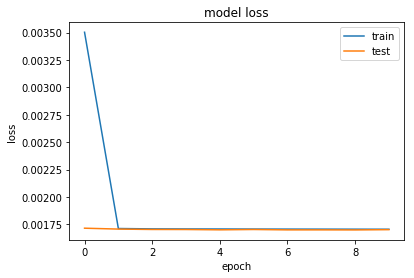

In [40]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');